# Set up

In [8]:
!git clone https://github.com/aliswh/lastfm
!cd lastfm; pip install -r requirements.txt

fatal: destination path 'lastfm' already exists and is not an empty directory.


In [9]:
!wget https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar
!cp gcs-connector-hadoop3-latest.jar /usr/local/lib/python3.7/dist-packages/pyspark/jars

--2022-03-01 10:22:35--  https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.80, 142.251.33.208, 142.251.45.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31607894 (30M) [application/java-archive]
Saving to: ‘gcs-connector-hadoop3-latest.jar.1’

gcs-connector-hadoo 100%[===================>]  30.14M   100MB/s    in 0.3s    

2022-03-01 10:22:35 (100 MB/s) - ‘gcs-connector-hadoop3-latest.jar.1’ saved [31607894/31607894]



In [10]:
import json
import datetime

import pyspark
from pyspark.sql import SparkSession
from py4j.java_gateway import UserHelpAutoCompletion
from lastfm.src.ingestion_layer.googlestorage import *
from lastfm.src.ingestion_layer.pylastsource import *
from lastfm.src.ingestion_layer.config import *
from lastfm.src.ingestion_layer.batchwriter import *
from lastfm.src.ingestion_layer.pysparkreader import *

# Read data

In [11]:
spark = SparkSession.builder.appName('A4BD Project').getOrCreate()
sc = pyspark.SparkContext.getOrCreate()
reader = PySparkReader(sc)
source = PyLastSource(AUTH_DATA) # for tests

In [22]:
user_sessions_stats = {
    'user_avg_tracks': [],
    'user_avg_session': [],
    'user_avg_session_len' : []
    }

name_path = 'listening_sessions' + '_'
ls_stats_path = 'listening_sessions/listening_sessions_statistics/'

for key,value in user_sessions_stats.items():
  user_sessions_stats[key] = reader.read(ls_stats_path+name_path+key,dir=False).collect()[0]

user_sessions_stats['user_avg_tracks']

[['abernes', 1.833], ['kurtphyre', 1.471], ['Gunthar666', 4.0]]

# Show data

In [24]:
for key in user_sessions_stats.keys():
  user_sessions_stats[key] = {item[0]:item[1] for item in user_sessions_stats[key]}

user_sessions_stats

{'user_avg_session': {'Gunthar666': 2.25,
  'abernes': 10.083,
  'kurtphyre': 15.059},
 'user_avg_session_len': {'Gunthar666': 179.75,
  'abernes': 217.833,
  'kurtphyre': 243.471},
 'user_avg_tracks': {'Gunthar666': 4.0, 'abernes': 1.833, 'kurtphyre': 1.471}}

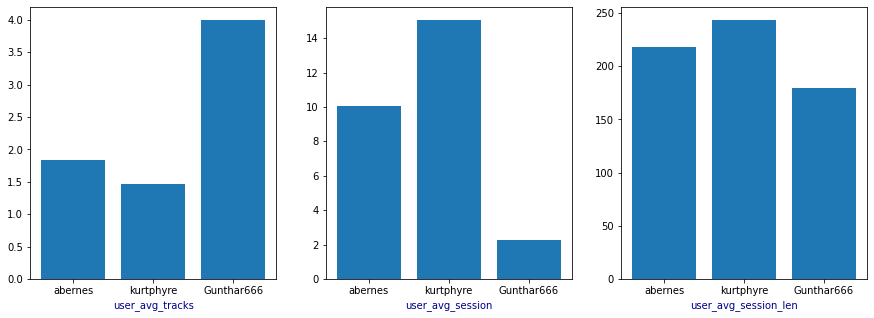

In [76]:
import matplotlib.pylab as plt

fig, ax = plt.subplots(1,3, figsize=(15,5))
for i,key in enumerate(user_sessions_stats.keys()):
  to_plot = user_sessions_stats[key]
  x,y = list(to_plot.keys()), list(to_plot.values())
  ax[i].bar(x,y)
  ax[i].set_xlabel(key, color='darkblue')